## Vanilla GAN with Fashion MNIST Dataset

This project will focus on building and training a simple GAN architecture with Fashion MNIST dataset. The architecture is referred as a "Vanilla" GAN, it is similar to the architecture that was proposed by Ian Goodfellow et al. Kindy refer this <a href="https://arxiv.org/abs/1406.2661" target="_blank">link</a> for more information.

In [1]:
# import libraries
import os
import time
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn, optim
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [2]:
# initialize variables
device: torch.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epoch_number: int = 100
latent_dimension: int = 100
batch_size: int = 32
discriminator_learning_rate: float = 0.0002
generator_learning_rate: float = 0.0002
checkpoint_path: str = os.path.join('model_checkpoint', 'vanilla_gan_fashion_mnist')
image_height: int = 28
image_width: int = 28
channel_number: int = 1

In [3]:
# functions for basic usage
def plot_generator_image(model):
    fixed_noise = torch.randn(int(batch_size / 2), latent_dimension)
    model.eval()

    with torch.no_grad():
        images = model(fixed_noise.to(device))
        images = images.detach().cpu().view((images.shape[0], 28, 28))

    plt.figure(figsize = (20, 4))

    num_row = 2
    num_col = int(images.shape[0] / num_row)

    for i, image in enumerate(images):
        plt.subplot(num_row, num_col, i + 1)
        plt.imshow(image, cmap = 'gray')
        plt.axis('off')

    plt.show()

def generate_images_result(model):
    noise = torch.randn(batch_size, latent_dimension)
    model.eval()

    with torch.no_grad():
        images = model(noise.to(device))
        images = images.cpu().view((images.shape[0]), 28, 28)

    nbr_row = 4
    nbr_col = int(noise.shape[0] / nbr_row)

    plt.figure(figsize = (25, 10))

    for i, image in enumerate(images):
        plt.subplot(nbr_row, nbr_col, i + 1)
        plt.imshow(image, cmap = 'gray')
        plt.axis('off')  

    plt.show()

def plot_loss_result(metrics, ylabel = None, ylim = None, metric_name = None, color = None):
    fig, ax = plt.subplots(figsize = (18, 5))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color = color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, epoch_number - 1])
    plt.ylim(ylim)

    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block = False)
    plt.close()

#### 1. Dataset Setup
Utilize the newly created transform_v2 for the FashionMNIST dataset. The dataset will be downloaded to the specified root directory if it's not already present. Adjust the root directory as needed.

In [4]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean = [0.5], std = [0.5])
])

training_dataset = datasets.FashionMNIST(
    root = '../../dataset',
    train = True,
    download = True,
    transform = transform
)

training_dataloader = DataLoader(
    dataset = training_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 1
)

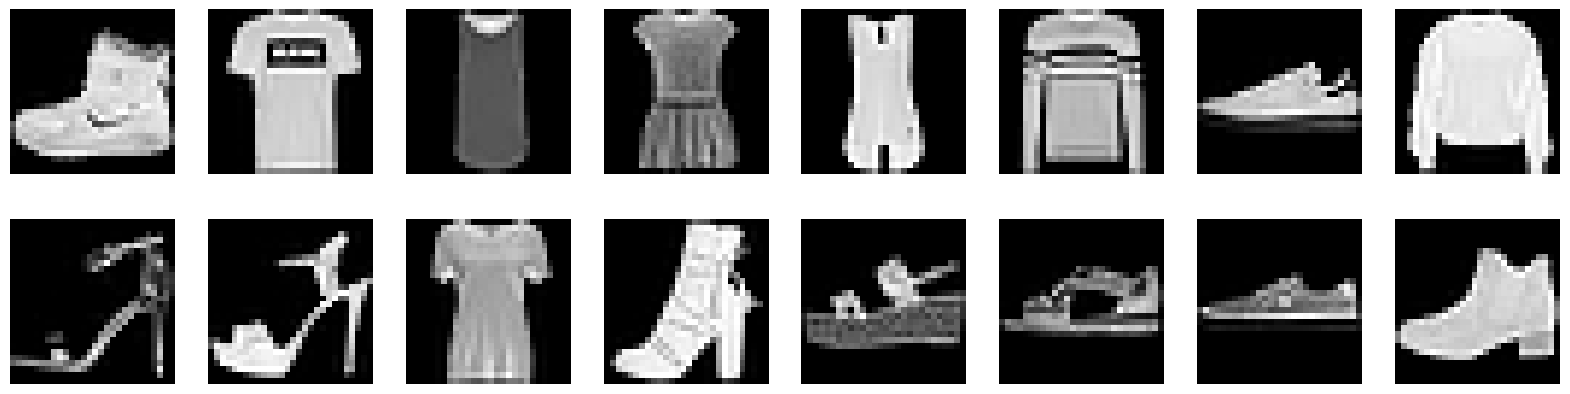

In [5]:
# visualization
plt.figure(figsize = (20, 5))

row_number, col_number = 2, 8

for i in range(row_number * col_number):
    ax = plt.subplot(row_number, col_number, i + 1)
    # resize (1, 28, 28) to (28, 28)
    plt.imshow(training_dataset[i][0].view((28, 28)), cmap = 'gray')
    plt.axis("off")

#### 2. Network Architecture Creation
Generator Network - The generator network is designed to convert a noise vector into a 2-dimensional image. It is a combination of dense and fully connected layers within the architecture. The generator network comprises `Linear` and `LeakyReLU` layers with an increased number of features. The utilization of `LeakyReLU` instead of `ReLU` is preferred due to its stability in training GANs. Notably, LeakyReLU was not initially incorporated into the GAN architecture in earlier papers. The activation function of the output layer is `Tanh`. Through experimentation over the years, researchers and practitioners have identified optimal practices for training GANs. 

The Fashion MNIST dataset consists of grayscale images with a resolution of 28 x 28 pixels, we expect generator network generates such images.  The final `Linear` layer has shape (1, 784), generator network will reshape these outputs (while taking the batch size into consideration) into (1, 28, 28) images by using `view()` function. Finally, the reshaped output (generated image) is returned. 

Discriminator network - It is very simple binary classification network. In this architecture, `Linear` layers will be used rather than convolutional layers. The input will be reshaped (flatten) first. This network is exclusively designed for solving a binary classification problem, the activation function of the output layer will be `Sigmoid`.

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(), # tanh is used for output images with pixel values in the range [-1, 1]
        )

    def forward(self, x):
        # convert (batch, 784) to (batch, 1, 28, 28)
        return self.generator(x).view(
            -1, 
            channel_number, 
            image_height, 
            image_width
        )

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.input_size = channel_number * image_height * image_width
        self.discriminator = nn.Sequential(
            nn.Linear(self.input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # sigmoid is used for binary classification
        )

    def forward(self, x):
        # convert (batch, 28, 28) to (batch, 784)
        x = x.view(-1, 784)
        return self.discriminator(x)

In [7]:
generator = Generator(latent_dim = latent_dimension).to(device)
print(generator)

total_params = sum(p.numel() for p in generator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in generator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Generator(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1024, out_features=784, bias=True)
    (9): Tanh()
  )
)
1,506,448 total parameters.
1,506,448 training parameters.


In [8]:
discriminator = Discriminator().to(device)
print(discriminator)

total_params = sum(p.numel() for p in discriminator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Discriminator(
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
533,505 total parameters.
533,505 training parameters.


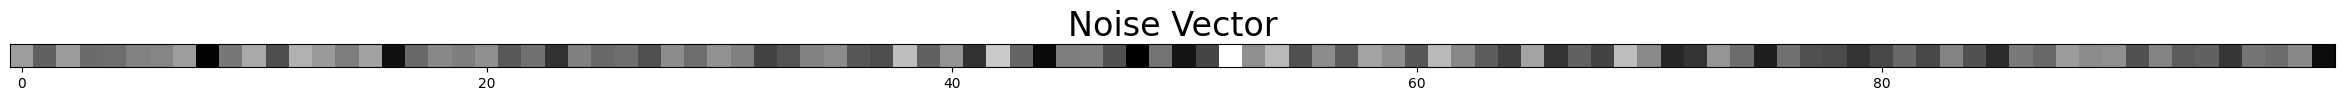

In [9]:
# create random noice and visualize it
noise = torch.randn(1, latent_dimension)

plt.figure(figsize = (30, 10))
plt.imshow(noise, cmap = 'gray')
plt.yticks([])
plt.title("Noise Vector", fontsize = 24)
plt.show()

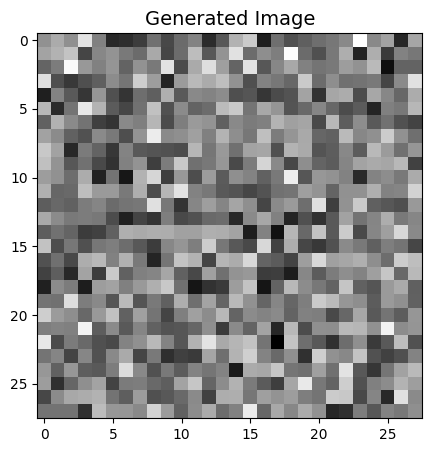

In [10]:
# generate fake image and visualize it
generated_image = generator(noise.to(device))
generated_image = generated_image.detach().cpu().view(28, 28)

plt.figure(figsize = (5, 5))
plt.imshow(generated_image, cmap = 'gray')
plt.title('Generated Image', fontsize = 14)
plt.show()

In [11]:
optimizer_generator = optim.Adam(
    generator.parameters(), 
    lr = generator_learning_rate,
    betas = (0.5, 0.999)
)

optimizer_discriminator = optim.Adam(
    discriminator.parameters(), 
    lr = discriminator_learning_rate,
    betas = (0.5, 0.999)
)

In [12]:
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

num_versions = len(os.listdir(checkpoint_path)) + 1
ckpt_version_dir = checkpoint_path + '/version_' + str(num_versions)

os.makedirs(ckpt_version_dir)

In [13]:
generator_ckpt = os.path.join(ckpt_version_dir, 'generator'+'.pth')
discriminatr_ckpt = os.path.join(ckpt_version_dir, 'discriminator'+'.pth')

In [14]:
bce = nn.BCELoss()

def loss_func(y_true, y_pred):
    loss = bce(y_pred, y_true)
    return loss

#### Model Training

In [15]:
def gan_training(real_image = None):
    # clear gradients of all optimizers
    optimizer_generator.zero_grad()
    optimizer_discriminator.zero_grad()

    # generate labels for discriminator network - 1 for real data and 0 for fake data
    labels = torch.cat(
        (torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), dim = 0
    ).to(device)
    # generate labels for generator network - 1 for real data
    misleading_labels = torch.ones(batch_size, 1).to(device)

    # create random noise
    noise = torch.randn(
        batch_size,
        latent_dimension
    ).to(device)

    # training discriminator network
    # generate fake images
    fake_image = generator(noise)

    # predicte labels from discriminator for real images
    y_pred_real = discriminator(real_image)
    # predicte labels from discriminator for fake images.
    y_pred_fake = discriminator(fake_image)

    # concatenate prediction for real and fake data
    y_pred_discriminator = torch.cat((y_pred_real, y_pred_fake), dim = 0)

    # compute the discriminator loss
    discriminator_loss = loss_func(labels, y_pred_discriminator)

    # discriminator network step
    discriminator_loss.backward()
    optimizer_discriminator.step()

    # training generator network
    # generate fake images
    fake_image = generator(noise)

    # predicte labels from discriminator for fake images
    y_pred_fake = discriminator(fake_image)

    # compute the generator loss
    generator_loss = loss_func(misleading_labels, y_pred_fake)

    # generator network step
    generator_loss.backward()
    optimizer_generator.step()

    return discriminator_loss, generator_loss

100%|██████████| 1875/1875 [00:09<00:00, 190.31it/s]




Training time for epoch 1 is 9.93441104888916 sec
Generator loss: 1.898, Discriminator loss: 0.425


100%|██████████| 1875/1875 [00:09<00:00, 193.20it/s]




Training time for epoch 2 is 9.822081327438354 sec
Generator loss: 1.642, Discriminator loss: 0.462


100%|██████████| 1875/1875 [00:10<00:00, 185.68it/s]




Training time for epoch 3 is 10.215797185897827 sec
Generator loss: 1.447, Discriminator loss: 0.488


100%|██████████| 1875/1875 [00:10<00:00, 175.06it/s]




Training time for epoch 4 is 10.829710245132446 sec
Generator loss: 1.351, Discriminator loss: 0.508


100%|██████████| 1875/1875 [00:11<00:00, 169.05it/s]




Training time for epoch 5 is 11.231675624847412 sec
Generator loss: 1.283, Discriminator loss: 0.514


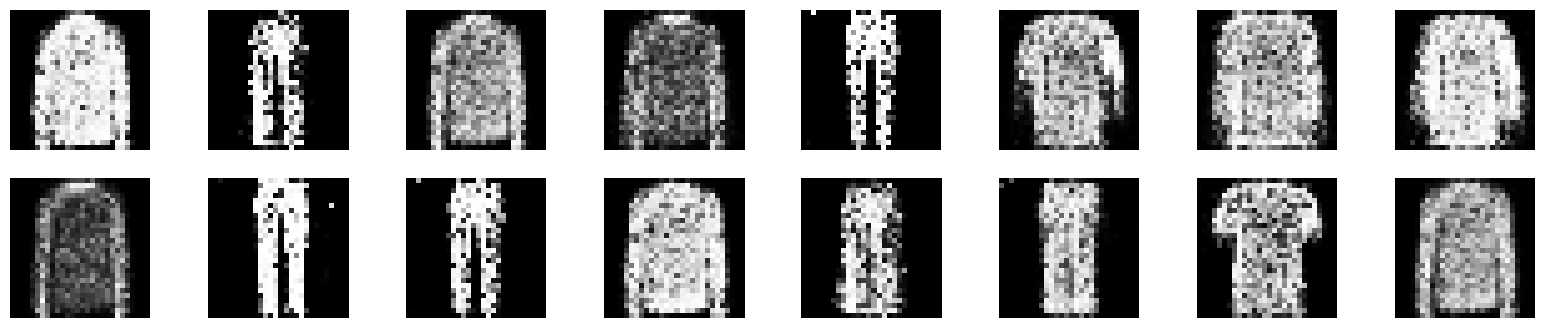

100%|██████████| 1875/1875 [00:10<00:00, 176.88it/s]




Training time for epoch 6 is 10.7229642868042 sec
Generator loss: 1.188, Discriminator loss: 0.530


100%|██████████| 1875/1875 [00:10<00:00, 177.22it/s]




Training time for epoch 7 is 10.69713044166565 sec
Generator loss: 1.144, Discriminator loss: 0.535


100%|██████████| 1875/1875 [00:11<00:00, 168.54it/s]




Training time for epoch 8 is 11.245930671691895 sec
Generator loss: 1.114, Discriminator loss: 0.537


100%|██████████| 1875/1875 [00:10<00:00, 176.21it/s]




Training time for epoch 9 is 10.762292623519897 sec
Generator loss: 1.103, Discriminator loss: 0.536


100%|██████████| 1875/1875 [00:10<00:00, 175.52it/s]




Training time for epoch 10 is 10.813416004180908 sec
Generator loss: 1.075, Discriminator loss: 0.543


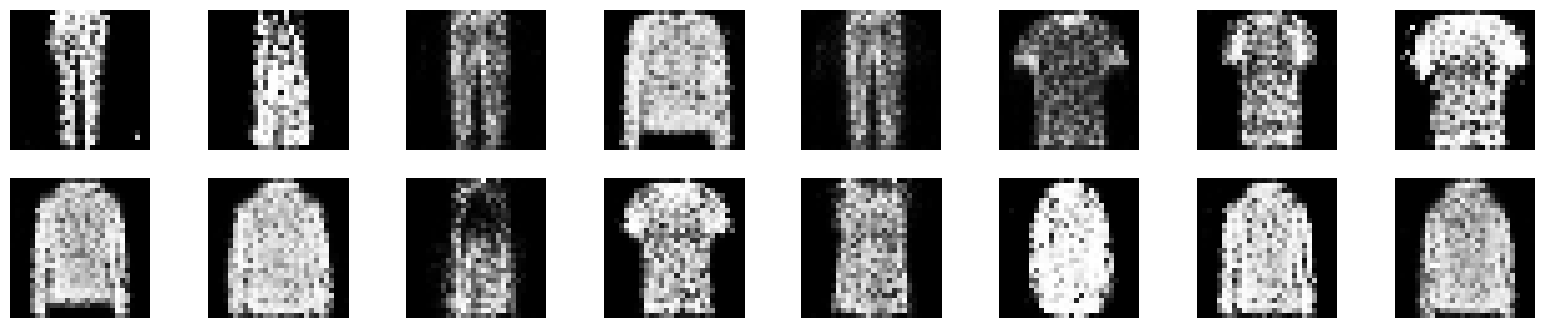

100%|██████████| 1875/1875 [00:11<00:00, 166.92it/s]




Training time for epoch 11 is 11.347983121871948 sec
Generator loss: 1.073, Discriminator loss: 0.541


100%|██████████| 1875/1875 [00:11<00:00, 162.94it/s]




Training time for epoch 12 is 11.6272714138031 sec
Generator loss: 1.070, Discriminator loss: 0.541


100%|██████████| 1875/1875 [00:13<00:00, 141.25it/s]




Training time for epoch 13 is 13.405503034591675 sec
Generator loss: 1.057, Discriminator loss: 0.544


100%|██████████| 1875/1875 [00:14<00:00, 127.46it/s]




Training time for epoch 14 is 14.849571943283081 sec
Generator loss: 1.048, Discriminator loss: 0.544


100%|██████████| 1875/1875 [00:19<00:00, 93.91it/s] 




Training time for epoch 15 is 20.17053508758545 sec
Generator loss: 1.048, Discriminator loss: 0.542


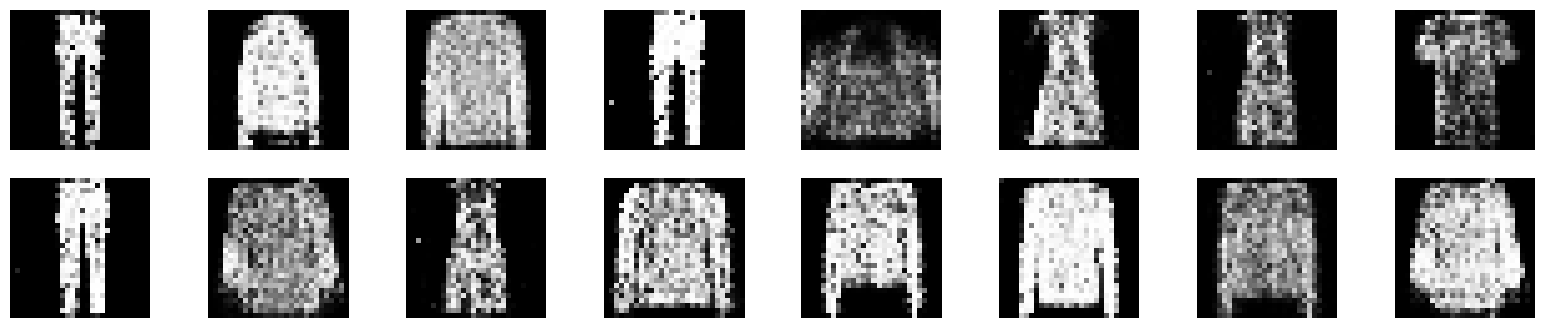

100%|██████████| 1875/1875 [00:19<00:00, 94.56it/s] 




Training time for epoch 16 is 20.021798849105835 sec
Generator loss: 1.042, Discriminator loss: 0.544


100%|██████████| 1875/1875 [00:19<00:00, 98.08it/s] 




Training time for epoch 17 is 19.31325364112854 sec
Generator loss: 1.038, Discriminator loss: 0.543


100%|██████████| 1875/1875 [00:18<00:00, 98.88it/s] 




Training time for epoch 18 is 19.151477098464966 sec
Generator loss: 1.039, Discriminator loss: 0.544


100%|██████████| 1875/1875 [00:16<00:00, 111.72it/s]




Training time for epoch 19 is 16.909245491027832 sec
Generator loss: 1.035, Discriminator loss: 0.545


100%|██████████| 1875/1875 [00:13<00:00, 135.95it/s]




Training time for epoch 20 is 14.03824782371521 sec
Generator loss: 1.029, Discriminator loss: 0.548


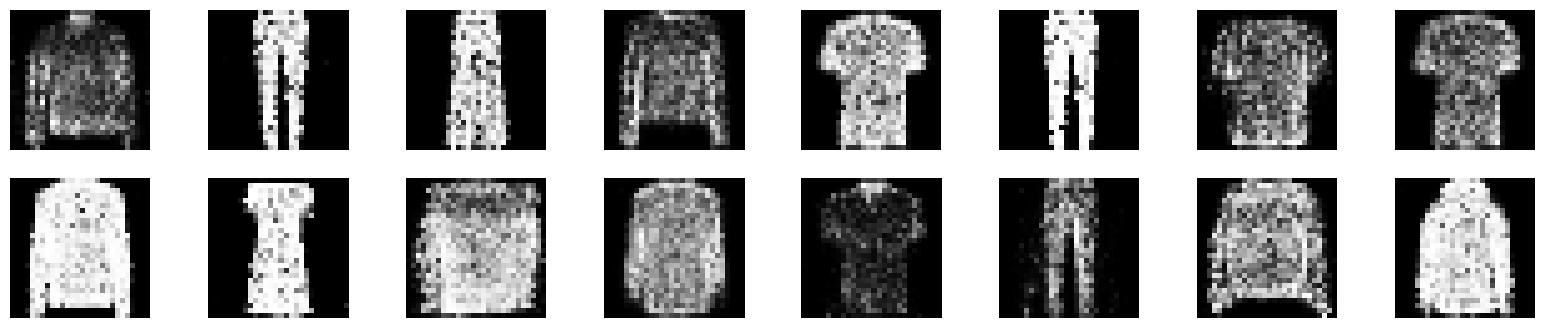

100%|██████████| 1875/1875 [00:13<00:00, 134.52it/s]




Training time for epoch 21 is 14.242133855819702 sec
Generator loss: 1.021, Discriminator loss: 0.550


100%|██████████| 1875/1875 [00:12<00:00, 144.28it/s]




Training time for epoch 22 is 13.123516321182251 sec
Generator loss: 1.029, Discriminator loss: 0.547


100%|██████████| 1875/1875 [00:13<00:00, 140.73it/s]




Training time for epoch 23 is 13.4625883102417 sec
Generator loss: 1.024, Discriminator loss: 0.548


100%|██████████| 1875/1875 [00:15<00:00, 121.98it/s]




Training time for epoch 24 is 15.513880729675293 sec
Generator loss: 1.025, Discriminator loss: 0.548


100%|██████████| 1875/1875 [00:13<00:00, 143.21it/s]




Training time for epoch 25 is 13.253527641296387 sec
Generator loss: 1.022, Discriminator loss: 0.549


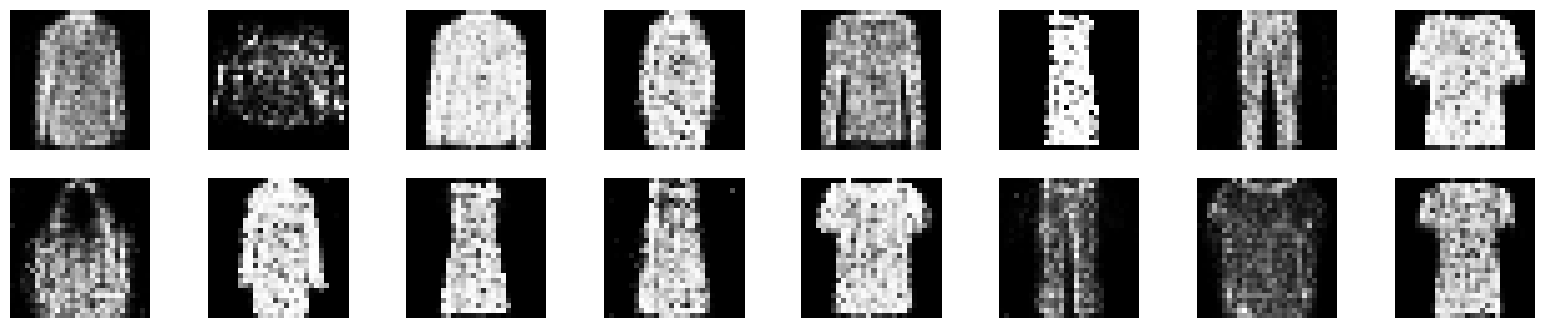

100%|██████████| 1875/1875 [00:13<00:00, 142.15it/s]




Training time for epoch 26 is 13.330164432525635 sec
Generator loss: 1.018, Discriminator loss: 0.552


100%|██████████| 1875/1875 [00:12<00:00, 149.35it/s]




Training time for epoch 27 is 12.68811583518982 sec
Generator loss: 1.024, Discriminator loss: 0.548


100%|██████████| 1875/1875 [00:12<00:00, 150.43it/s]




Training time for epoch 28 is 12.60470461845398 sec
Generator loss: 1.018, Discriminator loss: 0.553


100%|██████████| 1875/1875 [00:12<00:00, 146.50it/s]




Training time for epoch 29 is 12.939011335372925 sec
Generator loss: 1.016, Discriminator loss: 0.553


100%|██████████| 1875/1875 [00:12<00:00, 148.71it/s]




Training time for epoch 30 is 12.74805212020874 sec
Generator loss: 1.015, Discriminator loss: 0.555


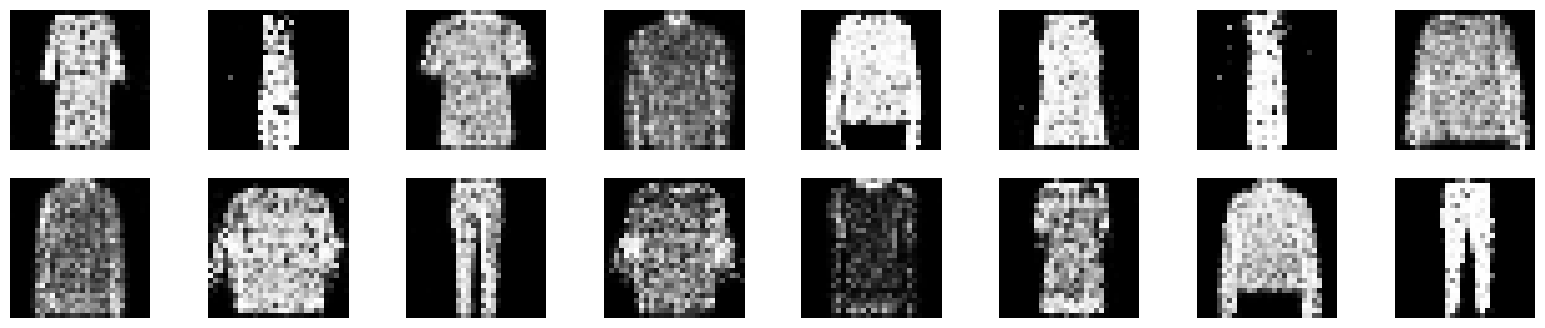

100%|██████████| 1875/1875 [00:15<00:00, 122.60it/s]




Training time for epoch 31 is 15.433530569076538 sec
Generator loss: 1.015, Discriminator loss: 0.554


100%|██████████| 1875/1875 [00:13<00:00, 139.81it/s]




Training time for epoch 32 is 13.547319173812866 sec
Generator loss: 1.016, Discriminator loss: 0.552


100%|██████████| 1875/1875 [00:13<00:00, 135.92it/s]




Training time for epoch 33 is 13.927698612213135 sec
Generator loss: 1.015, Discriminator loss: 0.552


100%|██████████| 1875/1875 [00:19<00:00, 97.75it/s] 




Training time for epoch 34 is 19.336841821670532 sec
Generator loss: 1.017, Discriminator loss: 0.554


100%|██████████| 1875/1875 [00:13<00:00, 135.17it/s]




Training time for epoch 35 is 14.031131029129028 sec
Generator loss: 1.020, Discriminator loss: 0.551


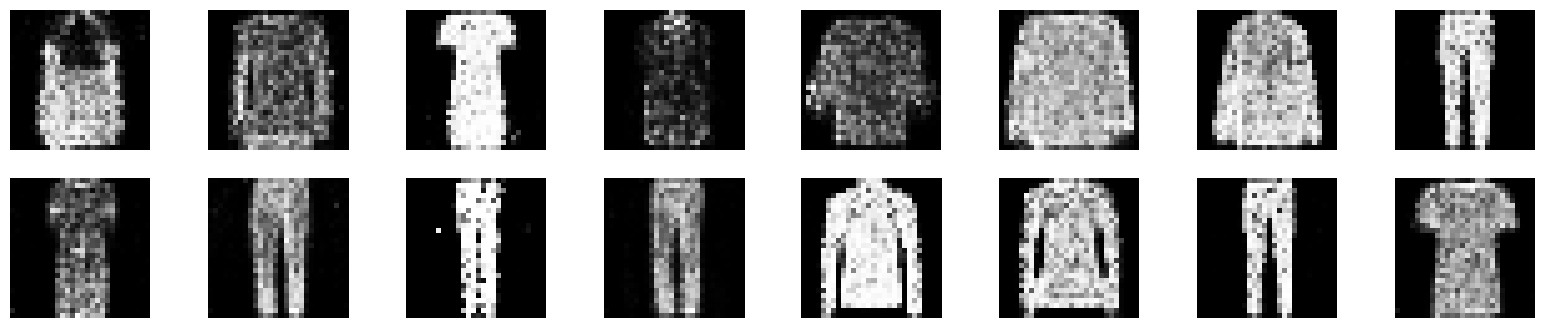

100%|██████████| 1875/1875 [00:16<00:00, 115.54it/s]




Training time for epoch 36 is 16.375699043273926 sec
Generator loss: 1.018, Discriminator loss: 0.552


100%|██████████| 1875/1875 [00:13<00:00, 142.75it/s]




Training time for epoch 37 is 13.267747640609741 sec
Generator loss: 1.018, Discriminator loss: 0.553


100%|██████████| 1875/1875 [00:12<00:00, 144.85it/s]




Training time for epoch 38 is 13.06661081314087 sec
Generator loss: 1.019, Discriminator loss: 0.553


100%|██████████| 1875/1875 [00:12<00:00, 149.11it/s]




Training time for epoch 39 is 12.702207326889038 sec
Generator loss: 1.019, Discriminator loss: 0.553


100%|██████████| 1875/1875 [00:12<00:00, 146.48it/s]




Training time for epoch 40 is 12.95149850845337 sec
Generator loss: 1.019, Discriminator loss: 0.552


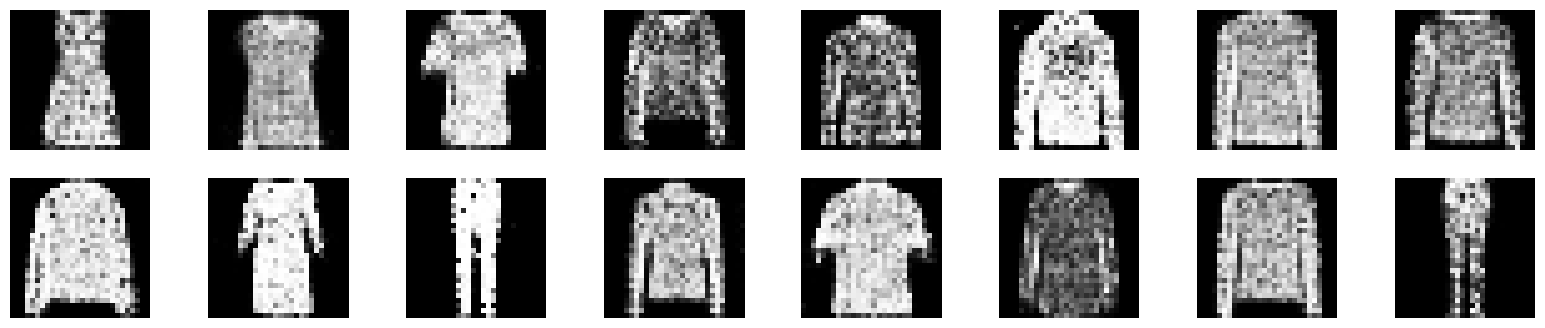

100%|██████████| 1875/1875 [00:12<00:00, 148.43it/s]




Training time for epoch 41 is 12.753811836242676 sec
Generator loss: 1.019, Discriminator loss: 0.554


100%|██████████| 1875/1875 [00:12<00:00, 148.75it/s]




Training time for epoch 42 is 12.748172998428345 sec
Generator loss: 1.019, Discriminator loss: 0.553


100%|██████████| 1875/1875 [00:12<00:00, 149.96it/s]




Training time for epoch 43 is 12.628620386123657 sec
Generator loss: 1.018, Discriminator loss: 0.553


100%|██████████| 1875/1875 [00:12<00:00, 147.44it/s]




Training time for epoch 44 is 12.835927486419678 sec
Generator loss: 1.024, Discriminator loss: 0.550


100%|██████████| 1875/1875 [00:12<00:00, 148.76it/s]




Training time for epoch 45 is 12.73855209350586 sec
Generator loss: 1.025, Discriminator loss: 0.549


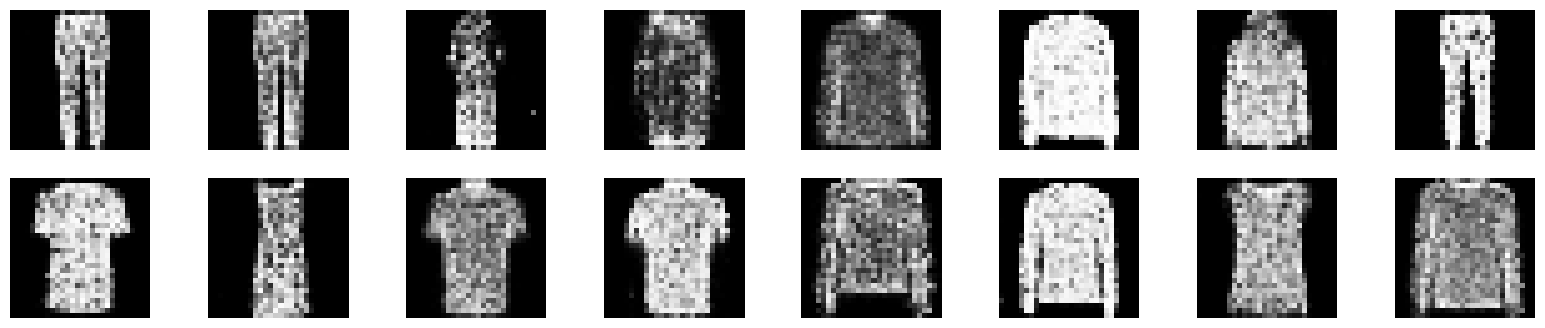

100%|██████████| 1875/1875 [00:12<00:00, 145.08it/s]




Training time for epoch 46 is 13.048872947692871 sec
Generator loss: 1.020, Discriminator loss: 0.552


100%|██████████| 1875/1875 [00:12<00:00, 148.01it/s]




Training time for epoch 47 is 12.789779901504517 sec
Generator loss: 1.023, Discriminator loss: 0.551


100%|██████████| 1875/1875 [00:12<00:00, 148.48it/s]




Training time for epoch 48 is 12.759271144866943 sec
Generator loss: 1.022, Discriminator loss: 0.551


100%|██████████| 1875/1875 [00:12<00:00, 149.08it/s]




Training time for epoch 49 is 12.707373857498169 sec
Generator loss: 1.026, Discriminator loss: 0.549


100%|██████████| 1875/1875 [00:12<00:00, 148.67it/s]




Training time for epoch 50 is 12.756052255630493 sec
Generator loss: 1.027, Discriminator loss: 0.550


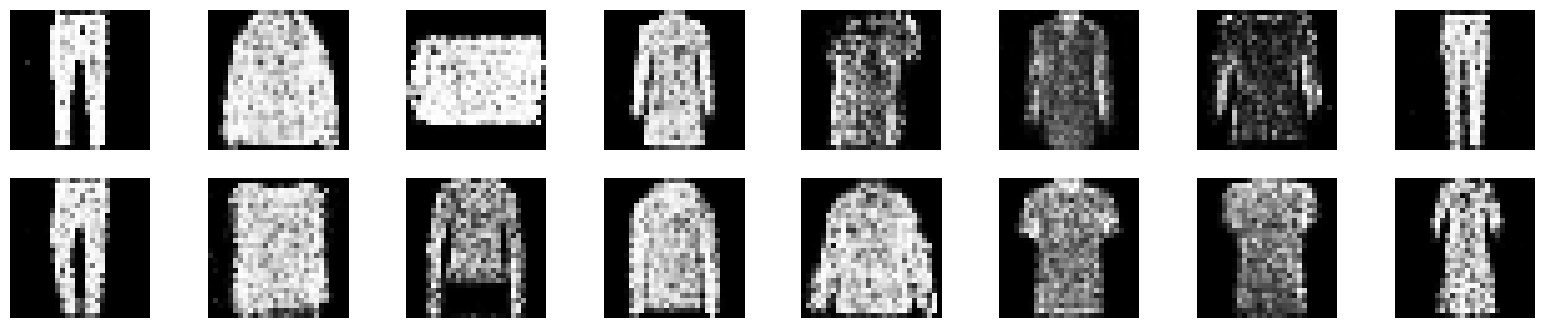

100%|██████████| 1875/1875 [00:12<00:00, 148.54it/s]




Training time for epoch 51 is 12.749225854873657 sec
Generator loss: 1.029, Discriminator loss: 0.549


100%|██████████| 1875/1875 [00:12<00:00, 148.01it/s]




Training time for epoch 52 is 12.804300785064697 sec
Generator loss: 1.029, Discriminator loss: 0.549


100%|██████████| 1875/1875 [00:12<00:00, 148.68it/s]




Training time for epoch 53 is 12.74861454963684 sec
Generator loss: 1.030, Discriminator loss: 0.548


100%|██████████| 1875/1875 [00:12<00:00, 148.44it/s]




Training time for epoch 54 is 12.764624118804932 sec
Generator loss: 1.034, Discriminator loss: 0.545


100%|██████████| 1875/1875 [00:14<00:00, 127.59it/s]




Training time for epoch 55 is 14.849802255630493 sec
Generator loss: 1.036, Discriminator loss: 0.545


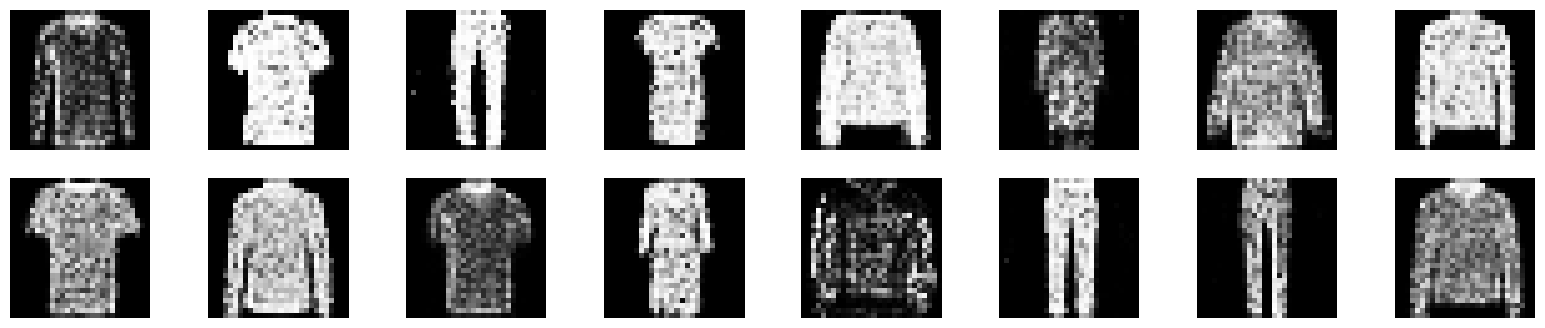

100%|██████████| 1875/1875 [00:14<00:00, 129.98it/s]




Training time for epoch 56 is 14.564457416534424 sec
Generator loss: 1.041, Discriminator loss: 0.543


100%|██████████| 1875/1875 [00:15<00:00, 117.41it/s]




Training time for epoch 57 is 16.10399055480957 sec
Generator loss: 1.037, Discriminator loss: 0.545


100%|██████████| 1875/1875 [00:13<00:00, 142.40it/s]




Training time for epoch 58 is 13.295596837997437 sec
Generator loss: 1.037, Discriminator loss: 0.545


100%|██████████| 1875/1875 [00:12<00:00, 147.45it/s]




Training time for epoch 59 is 12.853055000305176 sec
Generator loss: 1.042, Discriminator loss: 0.543


100%|██████████| 1875/1875 [00:12<00:00, 148.87it/s]




Training time for epoch 60 is 12.732375621795654 sec
Generator loss: 1.045, Discriminator loss: 0.541


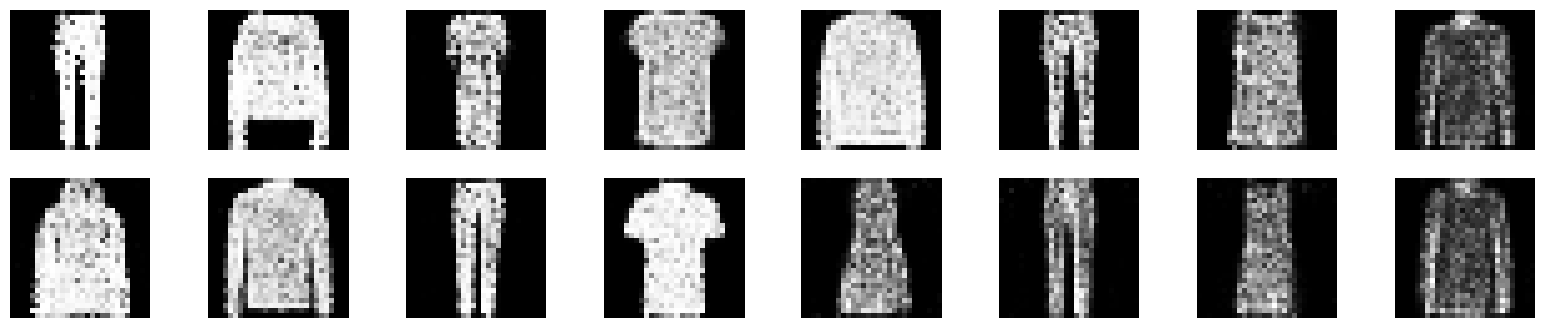

100%|██████████| 1875/1875 [00:12<00:00, 146.60it/s]




Training time for epoch 61 is 12.918482542037964 sec
Generator loss: 1.042, Discriminator loss: 0.544


100%|██████████| 1875/1875 [00:12<00:00, 147.75it/s]




Training time for epoch 62 is 12.821659088134766 sec
Generator loss: 1.041, Discriminator loss: 0.543


100%|██████████| 1875/1875 [00:12<00:00, 147.15it/s]




Training time for epoch 63 is 12.871984004974365 sec
Generator loss: 1.042, Discriminator loss: 0.543


100%|██████████| 1875/1875 [00:12<00:00, 146.64it/s]




Training time for epoch 64 is 12.909703493118286 sec
Generator loss: 1.047, Discriminator loss: 0.542


100%|██████████| 1875/1875 [00:12<00:00, 148.47it/s]




Training time for epoch 65 is 12.76477336883545 sec
Generator loss: 1.045, Discriminator loss: 0.542


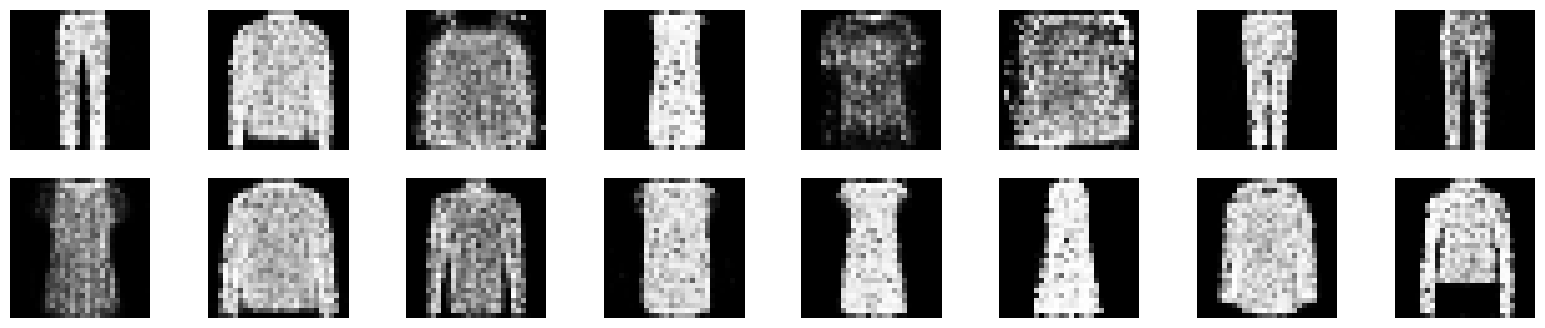

100%|██████████| 1875/1875 [00:12<00:00, 147.99it/s]




Training time for epoch 66 is 12.791566610336304 sec
Generator loss: 1.054, Discriminator loss: 0.538


100%|██████████| 1875/1875 [00:12<00:00, 147.16it/s]




Training time for epoch 67 is 12.864794492721558 sec
Generator loss: 1.052, Discriminator loss: 0.540


100%|██████████| 1875/1875 [00:10<00:00, 171.02it/s]




Training time for epoch 68 is 11.07654333114624 sec
Generator loss: 1.056, Discriminator loss: 0.538


100%|██████████| 1875/1875 [00:10<00:00, 171.84it/s]




Training time for epoch 69 is 11.030282020568848 sec
Generator loss: 1.063, Discriminator loss: 0.534


100%|██████████| 1875/1875 [00:10<00:00, 172.60it/s]




Training time for epoch 70 is 10.991437911987305 sec
Generator loss: 1.064, Discriminator loss: 0.533


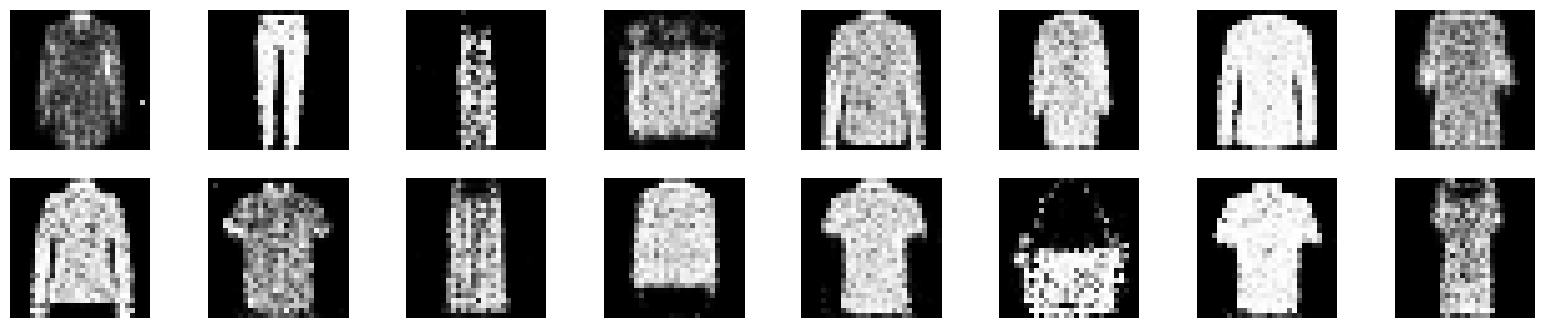

100%|██████████| 1875/1875 [00:11<00:00, 168.71it/s]




Training time for epoch 71 is 11.227918148040771 sec
Generator loss: 1.067, Discriminator loss: 0.532


100%|██████████| 1875/1875 [00:11<00:00, 170.09it/s]




Training time for epoch 72 is 11.14336085319519 sec
Generator loss: 1.069, Discriminator loss: 0.532


100%|██████████| 1875/1875 [00:10<00:00, 171.43it/s]




Training time for epoch 73 is 11.055300951004028 sec
Generator loss: 1.072, Discriminator loss: 0.531


100%|██████████| 1875/1875 [00:10<00:00, 171.76it/s]




Training time for epoch 74 is 11.032526016235352 sec
Generator loss: 1.073, Discriminator loss: 0.531


100%|██████████| 1875/1875 [00:10<00:00, 172.66it/s]




Training time for epoch 75 is 10.986333847045898 sec
Generator loss: 1.072, Discriminator loss: 0.531


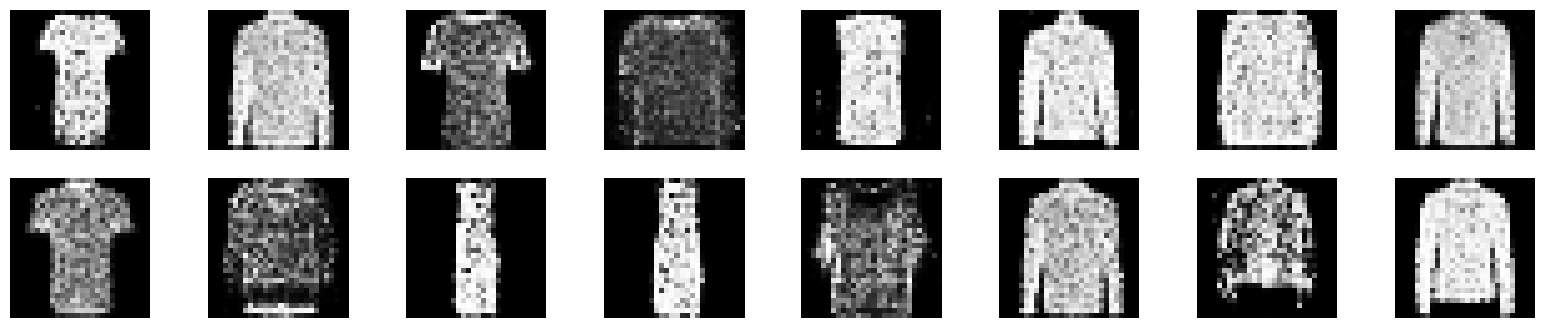

100%|██████████| 1875/1875 [00:11<00:00, 169.96it/s]




Training time for epoch 76 is 11.144631385803223 sec
Generator loss: 1.073, Discriminator loss: 0.531


100%|██████████| 1875/1875 [00:11<00:00, 169.28it/s]




Training time for epoch 77 is 11.203495740890503 sec
Generator loss: 1.080, Discriminator loss: 0.528


100%|██████████| 1875/1875 [00:10<00:00, 170.48it/s]




Training time for epoch 78 is 11.123299837112427 sec
Generator loss: 1.077, Discriminator loss: 0.529


100%|██████████| 1875/1875 [00:11<00:00, 168.60it/s]




Training time for epoch 79 is 11.23674464225769 sec
Generator loss: 1.083, Discriminator loss: 0.526


100%|██████████| 1875/1875 [00:11<00:00, 167.60it/s]




Training time for epoch 80 is 11.320157051086426 sec
Generator loss: 1.084, Discriminator loss: 0.527


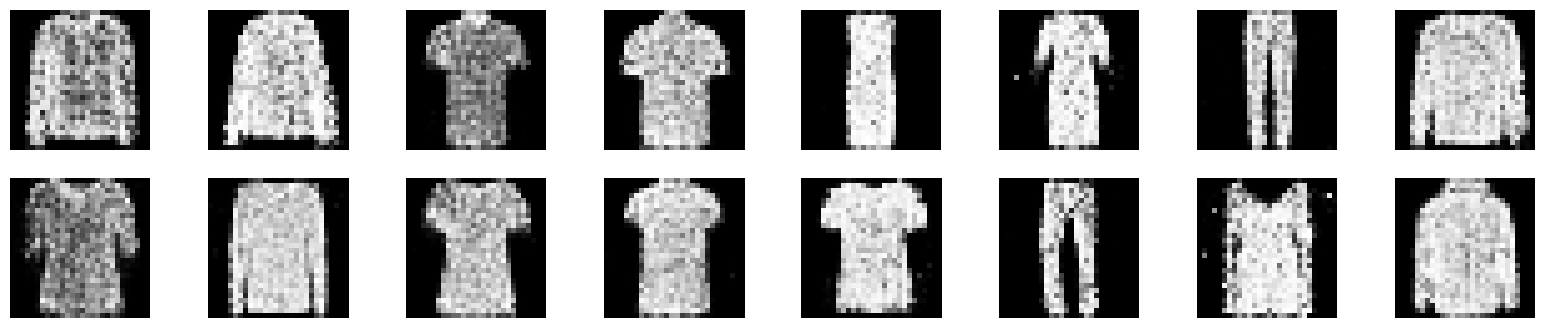

100%|██████████| 1875/1875 [00:11<00:00, 167.59it/s]




Training time for epoch 81 is 11.308242321014404 sec
Generator loss: 1.087, Discriminator loss: 0.524


100%|██████████| 1875/1875 [00:11<00:00, 168.92it/s]




Training time for epoch 82 is 11.219701051712036 sec
Generator loss: 1.089, Discriminator loss: 0.524


100%|██████████| 1875/1875 [00:10<00:00, 170.81it/s]




Training time for epoch 83 is 11.096972942352295 sec
Generator loss: 1.094, Discriminator loss: 0.521


100%|██████████| 1875/1875 [00:10<00:00, 172.44it/s]




Training time for epoch 84 is 10.994176626205444 sec
Generator loss: 1.093, Discriminator loss: 0.524


100%|██████████| 1875/1875 [00:10<00:00, 172.01it/s]




Training time for epoch 85 is 11.036679983139038 sec
Generator loss: 1.096, Discriminator loss: 0.522


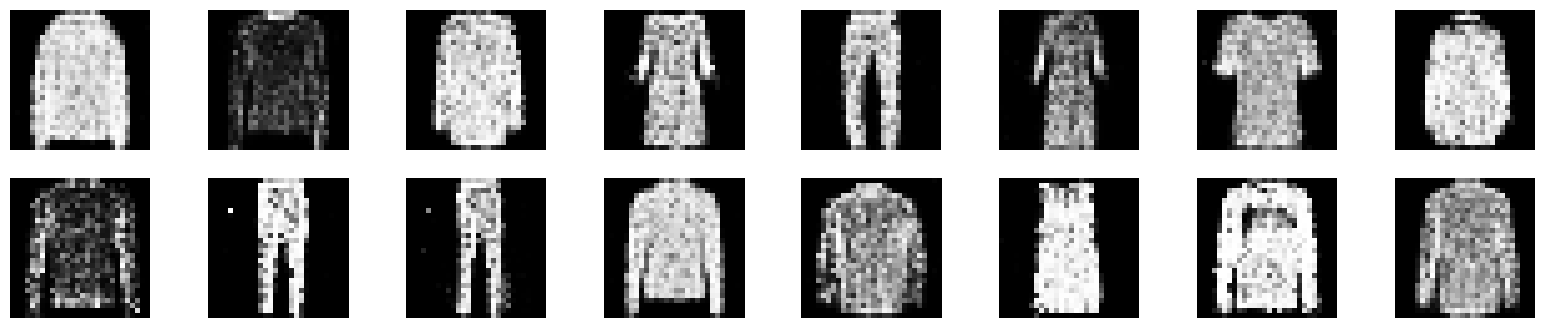

100%|██████████| 1875/1875 [00:10<00:00, 170.89it/s]




Training time for epoch 86 is 11.093012809753418 sec
Generator loss: 1.100, Discriminator loss: 0.520


100%|██████████| 1875/1875 [00:11<00:00, 169.97it/s]




Training time for epoch 87 is 11.163494110107422 sec
Generator loss: 1.097, Discriminator loss: 0.522


100%|██████████| 1875/1875 [00:11<00:00, 169.10it/s]




Training time for epoch 88 is 11.210350513458252 sec
Generator loss: 1.101, Discriminator loss: 0.520


100%|██████████| 1875/1875 [00:11<00:00, 167.87it/s]




Training time for epoch 89 is 11.28344178199768 sec
Generator loss: 1.103, Discriminator loss: 0.520


100%|██████████| 1875/1875 [00:10<00:00, 172.31it/s]



Training time for epoch 90 is 11.008432149887085 sec
Generator loss: 1.107, Discriminator loss: 0.518


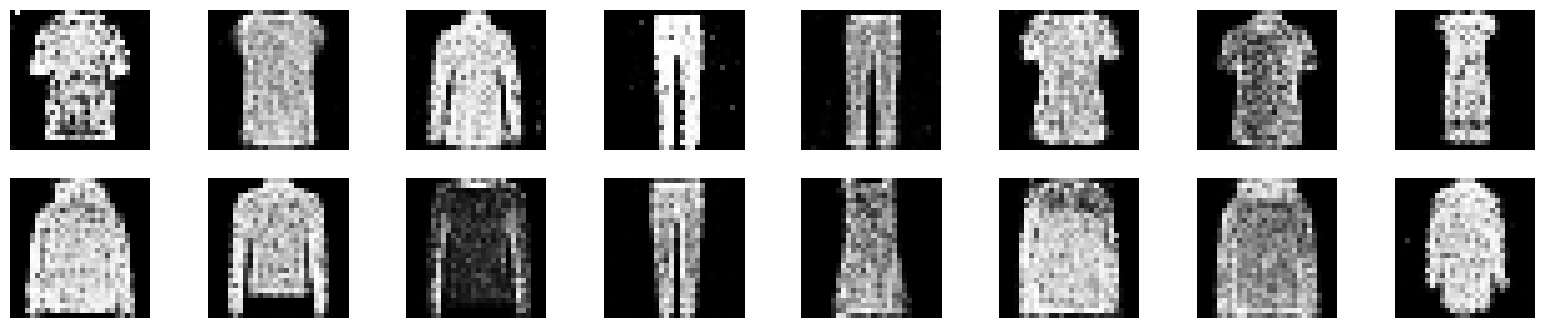

100%|██████████| 1875/1875 [00:11<00:00, 170.00it/s]




Training time for epoch 91 is 11.140424728393555 sec
Generator loss: 1.109, Discriminator loss: 0.519


100%|██████████| 1875/1875 [00:10<00:00, 171.89it/s]




Training time for epoch 92 is 11.021940469741821 sec
Generator loss: 1.110, Discriminator loss: 0.519


100%|██████████| 1875/1875 [00:11<00:00, 167.87it/s]




Training time for epoch 93 is 11.283317565917969 sec
Generator loss: 1.110, Discriminator loss: 0.518


100%|██████████| 1875/1875 [00:10<00:00, 173.91it/s]




Training time for epoch 94 is 10.913390636444092 sec
Generator loss: 1.116, Discriminator loss: 0.516


100%|██████████| 1875/1875 [00:11<00:00, 168.35it/s]




Training time for epoch 95 is 11.269491910934448 sec
Generator loss: 1.119, Discriminator loss: 0.515


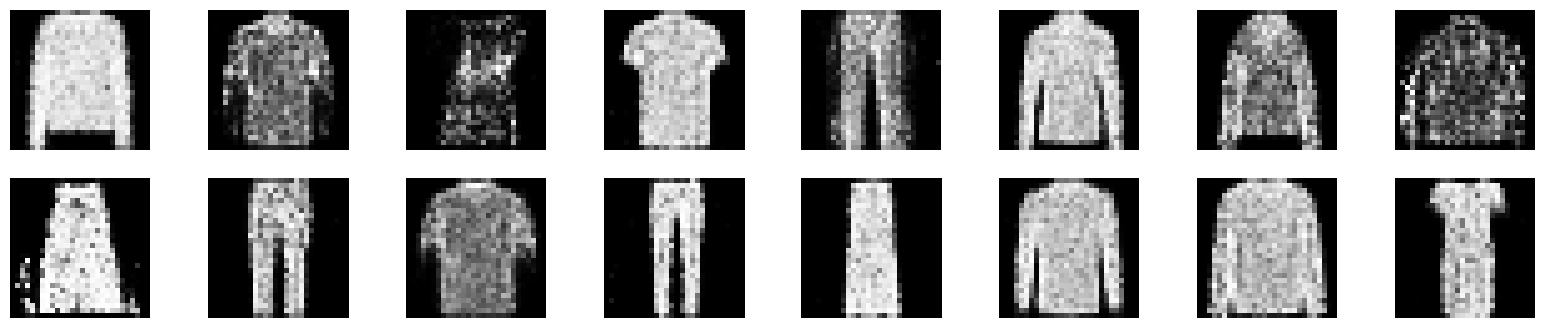

100%|██████████| 1875/1875 [00:11<00:00, 169.67it/s]




Training time for epoch 96 is 11.164041519165039 sec
Generator loss: 1.117, Discriminator loss: 0.515


100%|██████████| 1875/1875 [00:11<00:00, 169.26it/s]




Training time for epoch 97 is 11.194482803344727 sec
Generator loss: 1.120, Discriminator loss: 0.514


100%|██████████| 1875/1875 [00:11<00:00, 169.48it/s]




Training time for epoch 98 is 11.180347681045532 sec
Generator loss: 1.126, Discriminator loss: 0.513


100%|██████████| 1875/1875 [00:10<00:00, 170.91it/s]




Training time for epoch 99 is 11.085139751434326 sec
Generator loss: 1.130, Discriminator loss: 0.511


100%|██████████| 1875/1875 [00:10<00:00, 171.40it/s]




Training time for epoch 100 is 11.072542905807495 sec
Generator loss: 1.128, Discriminator loss: 0.512


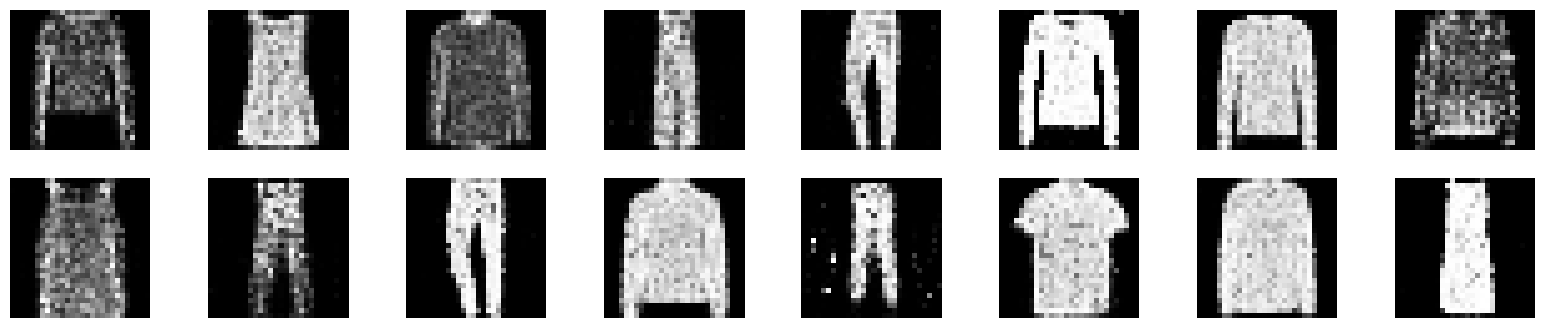

In [16]:
generator_loss = []
discriminator_loss = []

for epoch in range(epoch_number):
    # set training mode
    generator.train()
    discriminator.train()

    start = time.time()
    discriminator_loss_list, generator_loss_list = [], []

    for idx, data in tqdm(enumerate(training_dataloader), total = int(len(training_dataloader))):
        image_batch, label = data
        image_batch = image_batch.to(device)

        discriminator_loss_batch, generator_loss_batch = gan_training(image_batch)
        
        discriminator_loss_list.append(discriminator_loss_batch)
        generator_loss_list.append(generator_loss_batch)

    # save check point every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(generator, generator_ckpt)
        torch.save(discriminator, discriminatr_ckpt)

    epoch_discriminator_loss = sum(discriminator_loss_list) / len(discriminator_loss_list)
    epoch_generator_loss = sum(generator_loss_list) / len(generator_loss_list)

    discriminator_loss.append(epoch_discriminator_loss.detach().cpu())
    generator_loss.append(epoch_generator_loss.detach().cpu())
    
    print('\n')
    print(f"Training time for epoch {epoch + 1} is {time.time() - start} sec")
    print(f"Generator loss: {epoch_generator_loss:.3f}, Discriminator loss: {epoch_discriminator_loss:.3f}")

    # display every 5 epochs
    if (epoch + 1) % 5 == 0:
        plot_generator_image(generator)


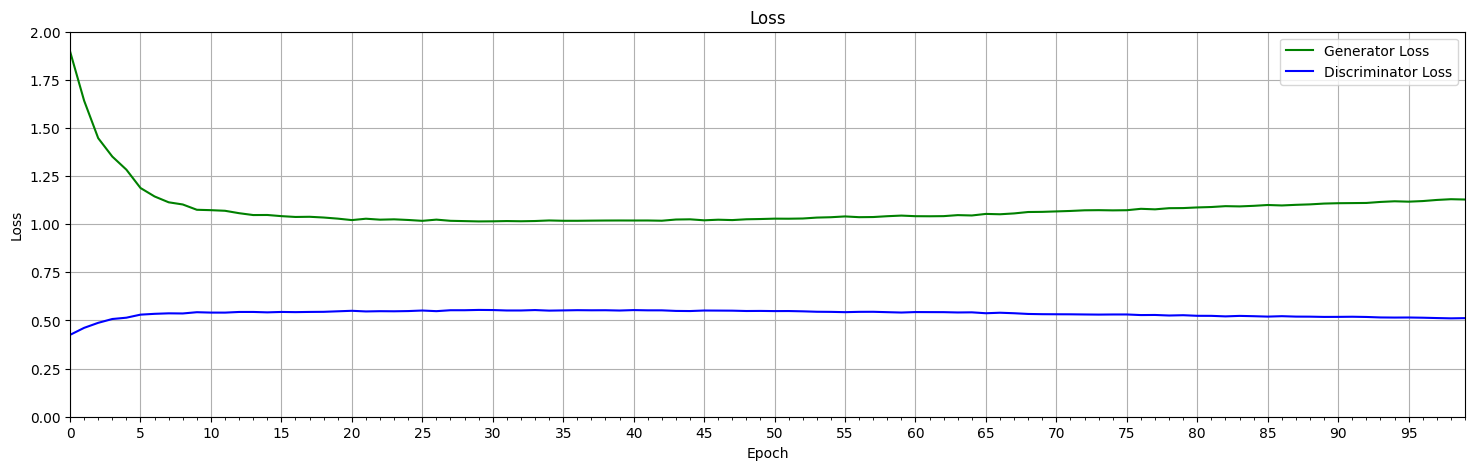

In [17]:
plot_loss_result([generator_loss, discriminator_loss], ylabel = "Loss", ylim = [0, 2],
    metric_name = ["Generator Loss", "Discriminator Loss"], color = ["g", "b"])

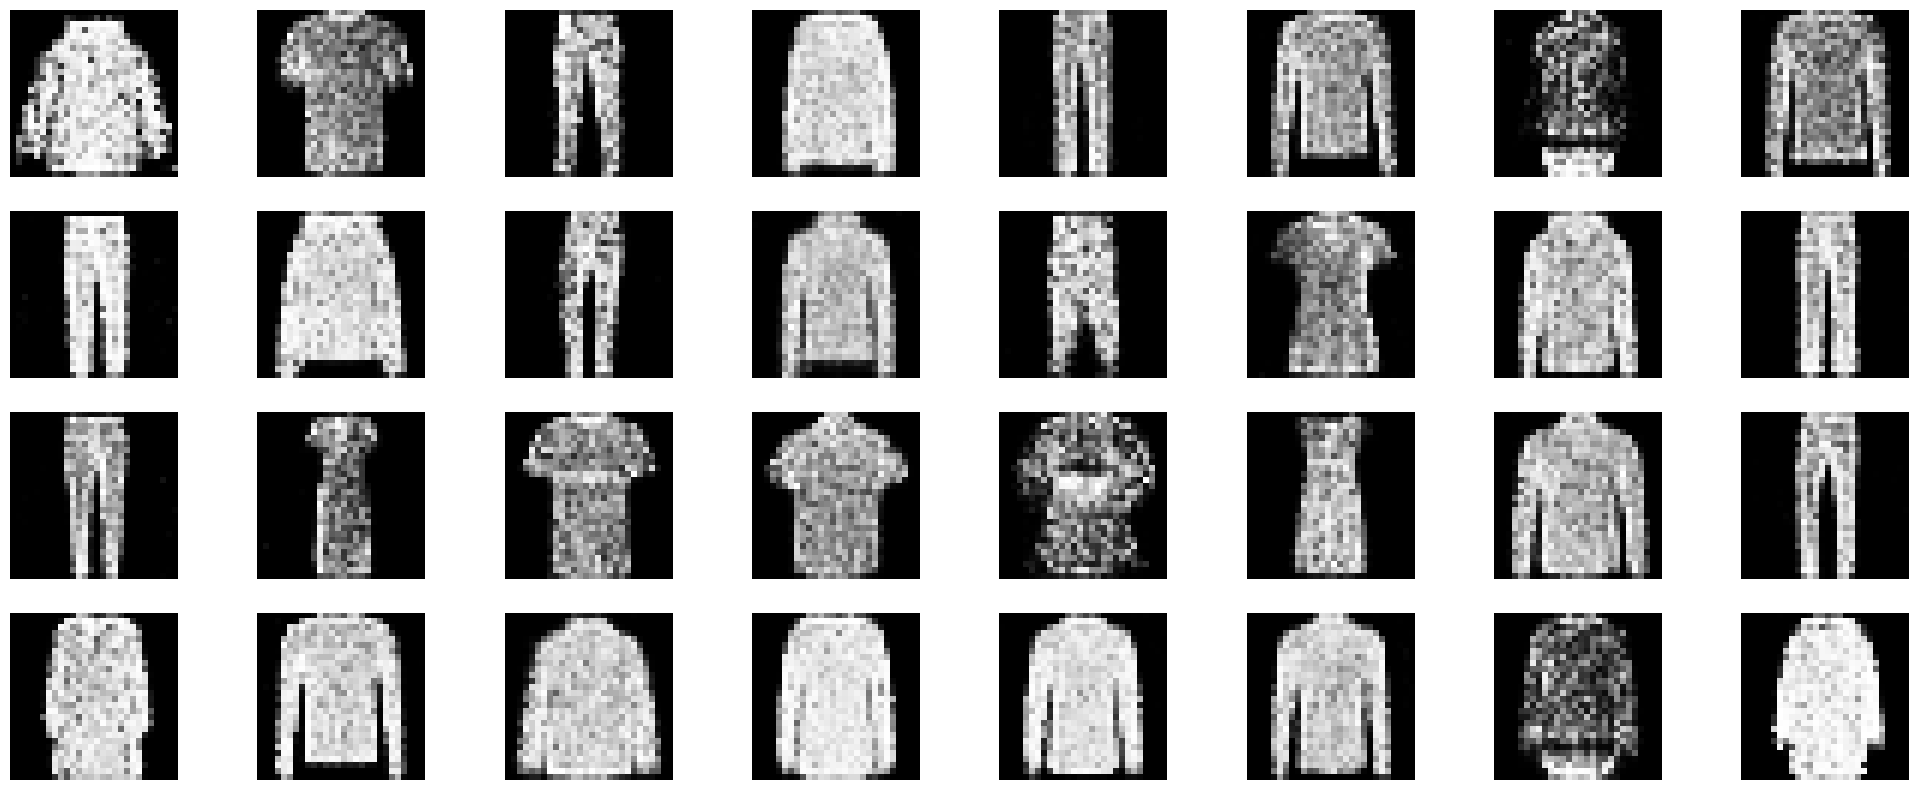

In [18]:
trained_generator = torch.load(generator_ckpt)
generate_images_result(trained_generator)